<a href="https://colab.research.google.com/github/helenmck1/SDS-bootcamp-2023_Tokyo/blob/main/christopher_session/SDS_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
# Install packages
!pip install pydeck-carto geopandas carto-auth[carto-dw] db_dtypes -q xgboost numpy shap matplotlib category-encoders seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.2 MB/s eta 0:00:00


In [ ]:
# Carto
import pydeck as pdk
import pydeck_carto as pdkc
from carto_auth import CartoAuth

# Analysis
import pandas as pd
import geopandas as gpd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import shap
import seaborn as sns

# ML
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Authentication

In [ ]:
# Authenticate Carto
carto_auth = CartoAuth.from_oauth()
carto_dw_client = carto_auth.get_carto_dw_client()

# Accessing Data

## CARTO Data Warehouse

In [ ]:
# List datasets in Carto Data Warehouse
datasets = list(carto_dw_client.list_datasets())

if datasets:
    print("Datasets in CARTO Data Warehouse:")
    for dataset in datasets:
        print("\t{}".format(dataset.dataset_id))
else:
    print("CARTO Data Warehouse project does not contain any datasets.")

Datasets in CARTO Data Warehouse:
	private_christopher_kyed_2_3b70a3aa
	shared
	shared_us
	workflows_temp_christopher_kyed_2_3b70a3aa
	workflows_temp_christopher_kyed_2_3b70a3aa_us


In [ ]:
# List tables in chosen dataset
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))


Tables contained in 'shared_us':
carto-dw-ac-u95100k3.shared_us.london_listings
carto-dw-ac-u95100k3.shared_us.london_listings_2023
carto-dw-ac-u95100k3.shared_us.london_listings_2023_joined
carto-dw-ac-u95100k3.shared_us.london_listings_joined


In [ ]:
# Load table
table = carto_dw_client.get_table("carto-dw-ac-u95100k3.shared_us.london_listings_2023")
gdf = carto_dw_client.list_rows(table).to_geodataframe(geography_column='geom', create_bqstorage_client=False)
display(gdf.head())

,geom,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,POINT (-0.10151 51.53470),431775,Rental unit in London · 1 bedroom · 1 bed · 1 ...,2146699,Mei-Ling,None,Islington,51.53470000000000000000000000000000000000,-0.10151000000000000000000000000000000000,Entire home/apt,115,3,0,NaT,None,1,0,0,None
1,POINT (-0.06979 51.55946),619258,Home in London · 1 bedroom · 1 bed · 2 baths,3080227,May,None,Hackney,51.55946000000000000000000000000000000000,-0.06979000000000000000000000000000000000,Private room,89,1,0,NaT,None,1,365,0,None
2,POINT (-0.21400 51.53672),2439331,Rental unit in London · 1 bedroom · 1 bed · 1 ...,885170,Joris,None,Brent,51.53672000000000000000000000000000000000,-0.21400000000000000000000000000000000000,Entire home/apt,60,5,0,NaT,None,1,0,0,None
3,POINT (-0.20260 51.52885),4109829,Rental unit in London · 1 bedroom · 1 bed · 1 ...,21181502,Jade,None,Westminster,51.52885000000000000000000000000000000000,-0.20260000000000000000000000000000000000,Private room,60,1,0,NaT,None,1,103,0,None
4,POINT (-0.13228 51.47784),4347791,Home in London · 1 bedroom · 1 bed · 1 bath,18958600,Tim,None,Lambeth,51.47784000000000000000000000000000000000,-0.13228000000000000000000000000000000000,Private room,20,14,0,NaT,None,1,0,0,None


## Data Observatory

In [ ]:
cdw_dataset = "carto-data.ac_u95100k3" # Provide your own Carto Data Warehouse ID here.
get_subscriptions_q = f"""
  CALL `carto-un`.carto.DATAOBS_SUBSCRIPTIONS('{cdw_dataset}',"dataset_license = 'Public data'");
  """

subs_df = carto_dw_client.query(get_subscriptions_q).result().to_dataframe(create_bqstorage_client=False)
display(subs_df)

,dataset_slug,dataset_name,dataset_country,dataset_category,dataset_license,dataset_provider,dataset_version,dataset_geo_type,dataset_table,associated_geography_table,associated_geography_slug
0,cdb_spatial_fea_6b8f8034,Spatial Features - United Kingdom (H3 Resoluti...,United Kingdom,Derived,Public data,CARTO,v2,POLYGON,sub_carto_derived_spatialfeatures_gbr_h3res8_v...,sub_carto_geography_gbr_h3res8_v1,cdb_h3res8_13269a73
1,cdrc_classificat_4b258856,Classification of Workplace Zones - United Kin...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_demographics_classificationofwork...,sub_gbr_cdrc_geography_gbr_workplacezone_2011,cdrc_workplace_z_ea87c1e4
2,cdrc_lower_super_f0adbc50,Lower Super Output Area - United Kingdom - Uni...,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,None,None
3,cdrc_residential_6d0ab56e,Residential Mobility Index - United Kingdom (L...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2020q3,MULTIPOLYGON,sub_gbr_cdrc_demographics_residentialmobilityi...,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,cdrc_lower_super_f0adbc50
4,cdrc_workplace_z_ea87c1e4,Workplace Zone - United Kingdom,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_workplacezone_2011,None,None
5,ons_ltla_a64e5794,Lower Tier Local Authority - United Kingdom (2...,United Kingdom,Geography,Public data,Office for National Statistics,2021,MULTIPOLYGON,sub_gbr_ons_geography_gbr_ltla_2021,None,None
6,osm_nodes_11b76f56,Nodes - United Kingdom of Great Britain and No...,United Kingdom,Points of Interest,Public data,OpenStreetMap,v1,POINT,sub_openstreetmap_pointsofinterest_nodes_gbr_l...,sub_openstreetmap_geography_gbr_latlon_v1,ostm_lat_lon_9dea3ef4
7,wp_population_a65e6bc5,Population Mosaics - United Kingdom (Grid 100m...,United Kingdom,Demographics,Public data,WorldPop,2020,POLYGON,sub_worldpop_demographics_population_gbr_grid1...,sub_worldpop_geography_gbr_grid100m_v1,wp_grid100m_2825c2a0


In [ ]:
local_auth_table = subs_df.query("dataset_slug == 'ons_ltla_a64e5794'")[['dataset_slug','dataset_name', 'dataset_table']]
display(local_auth_table)

,dataset_slug,dataset_name,dataset_table
5,ons_ltla_a64e5794,Lower Tier Local Authority - United Kingdom (2...,sub_gbr_ons_geography_gbr_ltla_2021


In [ ]:
get_dataset_variables = f"""
CALL `carto-un`.carto.DATAOBS_SUBSCRIPTION_VARIABLES(
    "{cdw_dataset}",
    "dataset_slug = 'ons_ltla_a64e5794'");
"""
carto_dw_client.query(get_dataset_variables).result().to_dataframe(create_bqstorage_client=False)

,variable_slug,variable_name,variable_description,variable_type,variable_aggregation,dataset_slug,associated_geography_slug
0,do_label_a3d3d73f,do_label,Region Name,STRING,None,ons_ltla_a64e5794,None
1,geoid_bc1fd969,geoid,Geography Code,STRING,None,ons_ltla_a64e5794,None
2,geom_715dc7ea,geom,Geography,GEOGRAPHY,None,ons_ltla_a64e5794,None


In [ ]:
dataset_id, geography_id = subs_df.query("dataset_slug == 'ons_ltla_a64e5794'")[["dataset_table", "associated_geography_table"]].values.ravel()
print(dataset_id, geography_id)

sub_gbr_ons_geography_gbr_ltla_2021 None


In [ ]:
london_auth_q = f"""
  SELECT *
  FROM `carto-data.ac_u95100k3.sub_gbr_ons_geography_gbr_ltla_2021`
"""
london_auth = carto_dw_client.query(london_auth_q).result().to_dataframe(create_bqstorage_client=False)
london_auth.sample(5)

# Visualizing Data

## Data Observatory

In [ ]:
# Register CartoLayer in pydeck
pdkc.register_carto_layer()

# Render CartoLayer in pydeck with color_bins style
layer = pdk.Layer(
    "CartoLayer",
    data="SELECT geom, price FROM `carto-dw-ac-u95100k3.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    point_radius_min_pixels=2.5,
    get_fill_color=pdkc.styles.color_bins("price",[0, 100, 200, 300, 400, 500], "PinkYl"),
    get_line_color=[0, 0, 0, 100]
)

view_state = pdk.ViewState(latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8)
pdk.Deck(layer, map_style=pdk.map_styles.ROAD, initial_view_state=view_state).to_html(iframe_height=800)

<IPython.core.display.Javascript object>

In [ ]:
# Register CartoLayer in pydeck
pdkc.register_carto_layer()

# Render CartoLayer in pydeck with color_bins style
layer = pdk.Layer(
    "CartoLayer",
    data="SELECT h3, price FROM `carto-dw-ac-u95100k3.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    aggregation_exp=pdk.types.String("avg(price) as price"),
    aggregation_res_level=8,
    geo_column=pdk.types.String("h3"),
    get_fill_color=pdkc.styles.color_bins("price",[0, 100, 200, 300, 400, 500], "PurpOr"),
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.4,
    stroked=True,
    extruded=False,
    pickable=True
)

tooltip = {
    "html": "H3: <b>{id}</b><br />Price: <b>{price}</b>",
    "style": {"background": "grey", "color": "white", "font-family": '"Helvetica Neue", Arial', "z-index": "10000"},
}

view_state = pdk.ViewState(latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8)
pdk.Deck(layer, map_style=pdk.map_styles.ROAD, tooltip=tooltip, initial_view_state=view_state).to_html(iframe_height=800)

<IPython.core.display.Javascript object>

## Data Observatory

In [ ]:
get_subscriptions_q = f"""
  CALL `carto-un`.carto.DATAOBS_SUBSCRIPTIONS('{cdw_dataset}',"dataset_license = 'Public data'");
  """

subs_df = carto_dw_client.query(get_subscriptions_q).result().to_dataframe(create_bqstorage_client=False)
display(subs_df)

,dataset_slug,dataset_name,dataset_country,dataset_category,dataset_license,dataset_provider,dataset_version,dataset_geo_type,dataset_table,associated_geography_table,associated_geography_slug
0,cdb_spatial_fea_6b8f8034,Spatial Features - United Kingdom (H3 Resoluti...,United Kingdom,Derived,Public data,CARTO,v2,POLYGON,sub_carto_derived_spatialfeatures_gbr_h3res8_v...,sub_carto_geography_gbr_h3res8_v1,cdb_h3res8_13269a73
1,cdrc_classificat_4b258856,Classification of Workplace Zones - United Kin...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_demographics_classificationofwork...,sub_gbr_cdrc_geography_gbr_workplacezone_2011,cdrc_workplace_z_ea87c1e4
2,cdrc_lower_super_f0adbc50,Lower Super Output Area - United Kingdom - Uni...,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,None,None
3,cdrc_residential_6d0ab56e,Residential Mobility Index - United Kingdom (L...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2020q3,MULTIPOLYGON,sub_gbr_cdrc_demographics_residentialmobilityi...,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,cdrc_lower_super_f0adbc50
4,cdrc_workplace_z_ea87c1e4,Workplace Zone - United Kingdom,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_workplacezone_2011,None,None
5,ons_ltla_a64e5794,Lower Tier Local Authority - United Kingdom (2...,United Kingdom,Geography,Public data,Office for National Statistics,2021,MULTIPOLYGON,sub_gbr_ons_geography_gbr_ltla_2021,None,None
6,osm_nodes_11b76f56,Nodes - United Kingdom of Great Britain and No...,United Kingdom,Points of Interest,Public data,OpenStreetMap,v1,POINT,sub_openstreetmap_pointsofinterest_nodes_gbr_l...,sub_openstreetmap_geography_gbr_latlon_v1,ostm_lat_lon_9dea3ef4
7,wp_population_a65e6bc5,Population Mosaics - United Kingdom (Grid 100m...,United Kingdom,Demographics,Public data,WorldPop,2020,POLYGON,sub_worldpop_demographics_population_gbr_grid1...,sub_worldpop_geography_gbr_grid100m_v1,wp_grid100m_2825c2a0


In [ ]:
dataset_id, geography_id = subs_df.query("dataset_name == 'Lower Tier Local Authority - United Kingdom (2021)'")[["dataset_table", "associated_geography_table"]].values.ravel()

In [ ]:
# Register CartoLayer in pydeck
pdkc.register_carto_layer()
credentials = pdkc.get_layer_credentials(carto_auth)

enriched_layer = pdk.Layer(
    "CartoLayer",
    data = f"SELECT * FROM `{cdw_dataset}.{dataset_id}`",
    geo_column=pdk.types.String("geom"),
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=credentials,
    get_fill_color=[238, 77, 90],
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.2,
    pickable=True,
    stroked=True,
    )

tooltip = {
    "html": "geoid: <b>{geoid}</b><br />do_label <b>{do_label}</b>",
    "style": {"background": "grey", "color": "white", "font-family": '"Helvetica Neue", Arial', "z-index": "10000"},
}

view_state = pdk.ViewState(latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=5)
r = pdk.Deck(
    [enriched_layer],
    tooltip = tooltip,
    initial_view_state=view_state,
    map_style=pdk.map_styles.LIGHT,
)
r.to_html(iframe_height = 800)

<IPython.core.display.Javascript object>

In [ ]:
dataset_id, geography_id = subs_df.query("dataset_name == 'Residential Mobility Index - United Kingdom (Lower Super Output Area)'")[["dataset_table", "associated_geography_table"]].values.ravel()

In [ ]:
# Register CartoLayer in pydeck
pdkc.register_carto_layer()
credentials = pdkc.get_layer_credentials(carto_auth)

enriched_layer = pdk.Layer(
    "CartoLayer",
    data = f"""SELECT y2016, geom
    FROM `{cdw_dataset}.{dataset_id}` d
    JOIN `{cdw_dataset}.{geography_id}` g
    ON d.geoid = g.geoid""",
    geo_column=pdk.types.String("geom"),
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=credentials,
    get_fill_color=pdkc.styles.color_bins("y2016",[0, 0.07, 0.08, 0.09, 0.1, 0.11, 1], "Emrld"),
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.5,
    pickable=True,
    stroked=True,
    )

tooltip = {
    "html": "Mobility: <b>{y2016}</b>",
    "style": {"background": "grey", "color": "white", "font-family": '"Helvetica Neue", Arial', "z-index": "10000"},
}

view_state = pdk.ViewState(latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8)
r = pdk.Deck(
    [enriched_layer],
    tooltip = tooltip,
    initial_view_state=view_state,
    map_style=pdk.map_styles.LIGHT,
)
r.to_html(iframe_height = 800)

<IPython.core.display.Javascript object>

# Data preparation

In [ ]:
# Load table
table = carto_dw_client.get_table("carto-dw-ac-u95100k3.shared_us.london_listings_2023_joined")
gdf_load = carto_dw_client.list_rows(table).to_geodataframe(geography_column='geom', create_bqstorage_client=False)
idx = "index"
gdf_load = gdf_load.reset_index()
gdf_load = gdf_load.set_index(idx)
gdf_load

,h3_geo,h3,geom,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,h3_joined,population_joined,leisure_joined,tourism_joined,transportation_joined,workplace_zone,mobility
index,,,,,,,,,,,,,,,,,
0,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.04029 51.47970),Lewisham,Private room,58,1,0,None,306,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
1,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.03734 51.48134),Lewisham,Entire home/apt,95,3,2,0.97000000000000000000000000000000000000,160,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
2,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.03956 51.48076),Lewisham,Entire home/apt,44,6,1,0.01000000000000000000000000000000000000,0,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
3,POLYGON ((-0.0474888265921303 51.4840484606132...,88194ad045fffff,POINT (-0.04403 51.48165),Lewisham,Private room,36,7,3,0.49000000000000000000000000000000000000,170,88194ad045fffff,8076.051548,5,1,13,Metro suburbs,0.085938
4,POLYGON ((-0.0395569109798319 51.4897108143529...,88194ad04dfffff,POINT (-0.04098 51.48218),Lewisham,Private room,48,1,0,None,178,88194ad04dfffff,4883.326601,0,0,21,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,"POLYGON ((0.0350567448117929 51.5751758172616,...",88194e683bfffff,POINT (0.03428 51.57486),Redbridge,Entire home/apt,400,5,3,0.05000000000000000000000000000000000000,0,88194e683bfffff,1469.876338,0,0,1,Metro suburbs,0.061674
81751,POLYGON ((-0.0294199515948246 51.4106493144567...,88194ad085fffff,POINT (-0.03038 51.40354),Bromley,Private room,57,1,70,5.90000000000000000000000000000000000000,236,88194ad085fffff,3089.929155,20,0,17,Metro suburbs,0.123348
81752,POLYGON ((-0.0373412225013056 51.4049812292224...,88194ad0abfffff,POINT (-0.03656 51.40261),Bromley,Private room,200,1,0,None,365,88194ad0abfffff,4619.299667,5,0,12,Metro suburbs,0.123348


## Feature Analysis

In [ ]:
gdf_clean = gdf_load.drop(['h3_geo', 'h3', 'geom', 'h3_joined'], axis=1)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population_joined,leisure_joined,tourism_joined,transportation_joined,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Private room,58,1,0,None,306,6840.458714,55,5,66,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95,3,2,0.97000000000000000000000000000000000000,160,6840.458714,55,5,66,Metro suburbs,0.085938
2,Lewisham,Entire home/apt,44,6,1,0.01000000000000000000000000000000000000,0,6840.458714,55,5,66,Metro suburbs,0.085938
3,Lewisham,Private room,36,7,3,0.49000000000000000000000000000000000000,170,8076.051548,5,1,13,Metro suburbs,0.085938
4,Lewisham,Private room,48,1,0,None,178,4883.326601,0,0,21,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400,5,3,0.05000000000000000000000000000000000000,0,1469.876338,0,0,1,Metro suburbs,0.061674
81751,Bromley,Private room,57,1,70,5.90000000000000000000000000000000000000,236,3089.929155,20,0,17,Metro suburbs,0.123348
81752,Bromley,Private room,200,1,0,None,365,4619.299667,5,0,12,Metro suburbs,0.123348


In [ ]:
gdf_clean.rename(columns={"population_joined": "population",
                          "leisure_joined": "lesiure",
                          "tourism_joined": "tourism",
                          "transportation_joined": "transportation"}, inplace=True)
gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Private room,58,1,0,None,306,6840.458714,55,5,66,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95,3,2,0.97000000000000000000000000000000000000,160,6840.458714,55,5,66,Metro suburbs,0.085938
2,Lewisham,Entire home/apt,44,6,1,0.01000000000000000000000000000000000000,0,6840.458714,55,5,66,Metro suburbs,0.085938
3,Lewisham,Private room,36,7,3,0.49000000000000000000000000000000000000,170,8076.051548,5,1,13,Metro suburbs,0.085938
4,Lewisham,Private room,48,1,0,None,178,4883.326601,0,0,21,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400,5,3,0.05000000000000000000000000000000000000,0,1469.876338,0,0,1,Metro suburbs,0.061674
81751,Bromley,Private room,57,1,70,5.90000000000000000000000000000000000000,236,3089.929155,20,0,17,Metro suburbs,0.123348
81752,Bromley,Private room,200,1,0,None,365,4619.299667,5,0,12,Metro suburbs,0.123348


In [ ]:
categorical_variables = ['neighbourhood', 'room_type', 'workplace_zone'] # Categorical values
numerical_variables = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'population','lesiure','tourism','transportation','mobility'] # Numerical Values
target = 'price' # Target variable

In [ ]:
# Confirm types
gdf_clean.dtypes

neighbourhood         object
room_type             object
price                  Int64
minimum_nights         Int64
number_of_reviews      Int64
reviews_per_month     object
availability_365       Int64
population           float64
lesiure                Int64
tourism                Int64
transportation         Int64
workplace_zone        object
mobility             float64
dtype: object

In [ ]:
# Force types
for cat in categorical_variables:
  gdf_clean[cat] = gdf_clean[cat].astype('object')

for num in [numerical_variables + [target]]:
  gdf_clean[num] = gdf_clean[num].astype('float64')

gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Private room,58.0,1.0,0.0,NaN,306.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
2,Lewisham,Entire home/apt,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
3,Lewisham,Private room,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,Metro suburbs,0.085938
4,Lewisham,Private room,48.0,1.0,0.0,NaN,178.0,4883.326601,0.0,0.0,21.0,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,Metro suburbs,0.061674
81751,Bromley,Private room,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,Metro suburbs,0.123348
81752,Bromley,Private room,200.0,1.0,0.0,NaN,365.0,4619.299667,5.0,0.0,12.0,Metro suburbs,0.123348


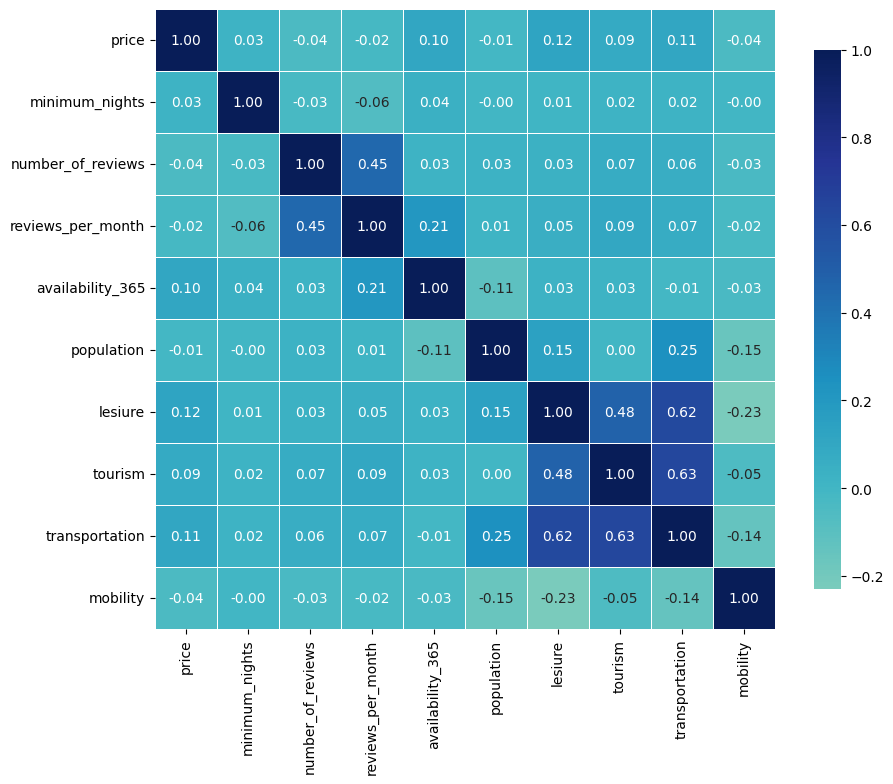

In [ ]:
correlations = gdf_clean.corr(numeric_only=True)

fig, axes = plt.subplots(figsize=(10,10), facecolor='white')
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=axes)
plt.show()

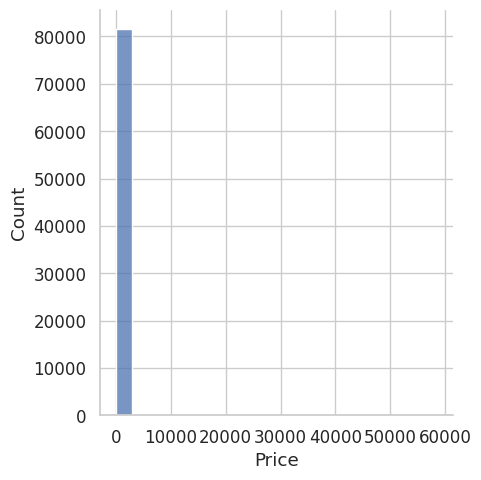

In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})
sns.displot(gdf_clean['price'], kde=False, bins=20,).set(xlabel='Price', ylabel='Count');

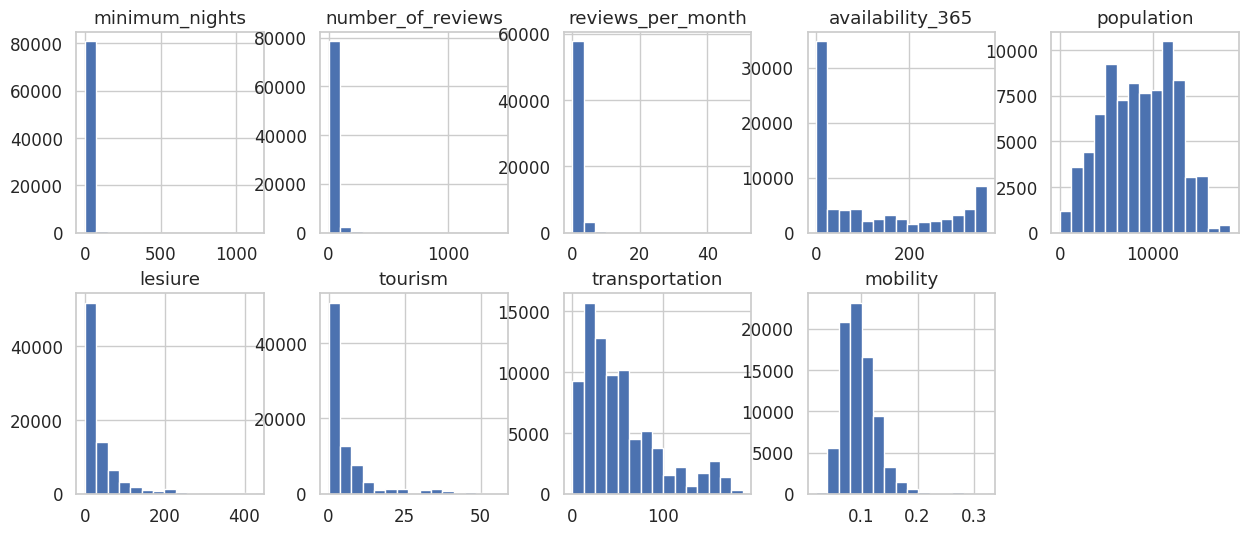

In [ ]:
gdf_clean[numerical_variables].hist(bins=15, figsize=(15, 6), layout=(2, 5));

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


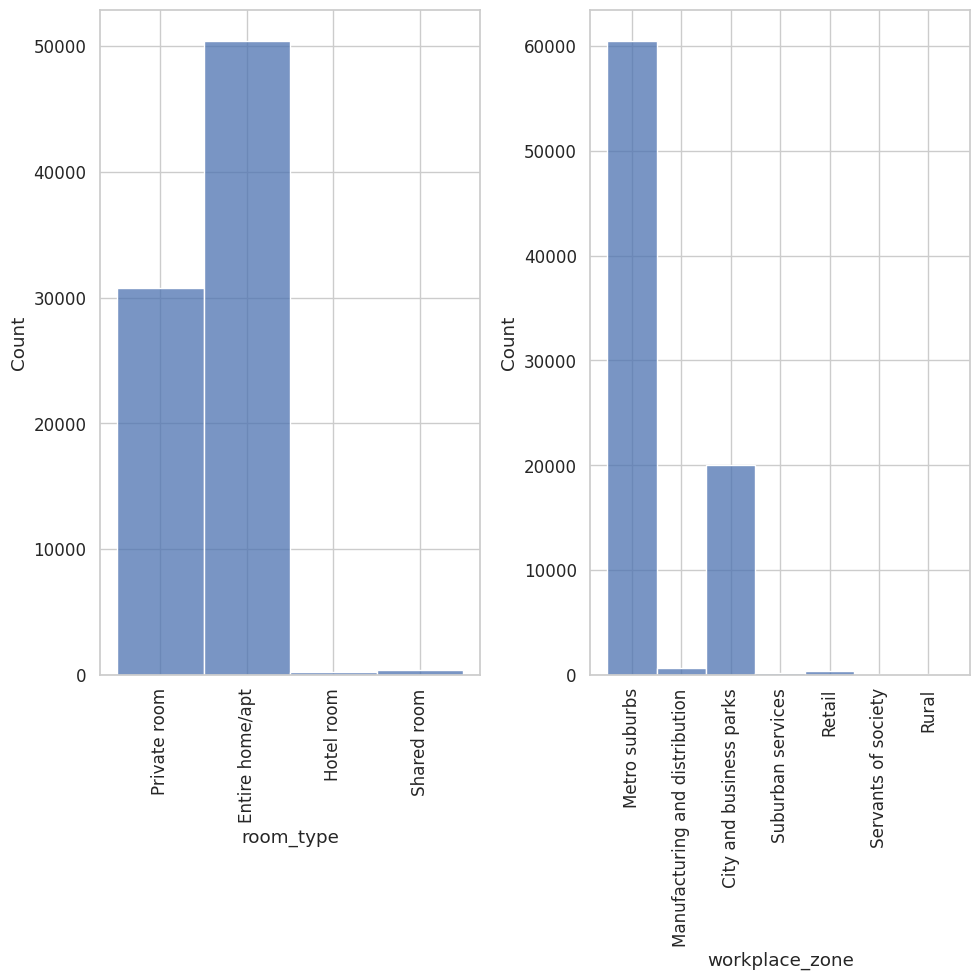

In [ ]:
# select the columns to be plotted
cols = ['room_type', 'workplace_zone']

# create the figure and axes
fig, axes = plt.subplots(1, 2)
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(gdf_clean[col], ax=ax).set_xticklabels(ax.get_xticklabels(),rotation=90)

fig.tight_layout()
plt.show()

## Null values and Outliers

In [ ]:
gdf_selected = gdf_clean.copy()
gdf_selected.describe(percentiles=[.25, .5, .75, .95, .99])

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility
count,81755.000000,81755.000000,81755.000000,61166.000000,81755.000000,81755.000000,81755.000000,81755.000000,81755.000000,81755.000000
mean,187.545508,5.648450,17.942695,0.970436,119.304948,8519.053966,36.522904,5.366767,52.397505,0.097697
std,477.538813,22.999768,42.247332,1.330555,133.869156,3745.084105,51.778037,8.736367,41.005148,0.030673
min,0.000000,1.000000,0.000000,0.010000,0.000000,10.962097,0.000000,0.000000,0.000000,0.021189
25%,61.000000,1.000000,0.000000,0.140000,0.000000,5634.368035,5.000000,0.000000,21.000000,0.076423
50%,110.000000,2.000000,4.000000,0.500000,59.000000,8637.996885,18.000000,2.000000,42.000000,0.092812
75%,198.000000,4.000000,16.000000,1.230000,245.000000,11479.420325,47.000000,6.000000,71.000000,0.113142
95%,514.300000,14.000000,82.000000,3.610000,361.000000,14366.825070,149.000000,26.000000,150.000000,0.148096
99%,1570.000000,90.000000,209.000000,6.100000,365.000000,15413.859685,233.000000,39.000000,165.000000,0.192593
max,58564.000000,1125.000000,1425.000000,50.500000,365.000000,18360.206098,427.000000,56.000000,187.000000,0.321531


In [ ]:
gdf_selected = gdf_selected[gdf_selected['price'] >= 10]
gdf_selected = gdf_selected[gdf_selected['price'] <= 1570]
gdf_selected = gdf_selected[gdf_selected['minimum_nights'] <= 90]
gdf_selected

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Private room,58.0,1.0,0.0,NaN,306.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
2,Lewisham,Entire home/apt,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
3,Lewisham,Private room,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,Metro suburbs,0.085938
4,Lewisham,Private room,48.0,1.0,0.0,NaN,178.0,4883.326601,0.0,0.0,21.0,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,Metro suburbs,0.061674
81751,Bromley,Private room,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,Metro suburbs,0.123348
81752,Bromley,Private room,200.0,1.0,0.0,NaN,365.0,4619.299667,5.0,0.0,12.0,Metro suburbs,0.123348


In [ ]:
display(gdf_selected.isnull().sum())

neighbourhood            0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
reviews_per_month    20147
availability_365         0
population               0
lesiure                  0
tourism                  0
transportation           0
workplace_zone           0
mobility                 0
dtype: int64

In [ ]:
gdf_selected = gdf_selected.fillna(0)
display(gdf_selected.isnull().sum())

neighbourhood        0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
reviews_per_month    0
availability_365     0
population           0
lesiure              0
tourism              0
transportation       0
workplace_zone       0
mobility             0
dtype: int64

## Encoding

In [ ]:
gdf_encoded = gdf_selected.copy()

In [ ]:
gdf_encoded = gdf_selected.copy()
display(gdf_encoded[categorical_variables])
for cat in categorical_variables:
    print(cat, gdf_encoded[cat].nunique())

,neighbourhood,room_type,workplace_zone
index,,,
0,Lewisham,Private room,Metro suburbs
1,Lewisham,Entire home/apt,Metro suburbs
2,Lewisham,Entire home/apt,Metro suburbs
3,Lewisham,Private room,Metro suburbs
4,Lewisham,Private room,Metro suburbs
...,...,...,...
81750,Redbridge,Entire home/apt,Metro suburbs
81751,Bromley,Private room,Metro suburbs
81752,Bromley,Private room,Metro suburbs


neighbourhood 33
room_type 4
workplace_zone 7


In [ ]:
# Nominal and cardinality < 15, use OneHot Encoding
gdf_encoded = pd.get_dummies(gdf_encoded, columns=["room_type", "workplace_zone"])

# Nominal and cardinality > 15, use Target Encoding
encoder = ce.TargetEncoder()
gdf_encoded["neighbourhood"] = encoder.fit_transform(gdf_encoded['neighbourhood'], gdf_encoded['price'])
gdf_encoded

,neighbourhood,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
0,99.253586,58.0,1.0,0.0,0.00,306.0,6840.458714,55.0,5.0,66.0,...,0,1,0,0,0,1,0,0,0,0
1,99.253586,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,...,0,0,0,0,0,1,0,0,0,0
2,99.253586,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,...,0,0,0,0,0,1,0,0,0,0
3,99.253586,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,...,0,1,0,0,0,1,0,0,0,0
4,99.253586,48.0,1.0,0.0,0.00,178.0,4883.326601,0.0,0.0,21.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,107.355499,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
81751,105.273115,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,...,0,1,0,0,0,1,0,0,0,0
81752,105.273115,200.0,1.0,0.0,0.00,365.0,4619.299667,5.0,0.0,12.0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
gdf_encoded.dtypes

neighbourhood                                    float64
price                                            float64
minimum_nights                                   float64
number_of_reviews                                float64
reviews_per_month                                float64
availability_365                                 float64
population                                       float64
lesiure                                          float64
tourism                                          float64
transportation                                   float64
mobility                                         float64
room_type_Entire home/apt                          uint8
room_type_Hotel room                               uint8
room_type_Private room                             uint8
room_type_Shared room                              uint8
workplace_zone_City and business parks             uint8
workplace_zone_Manufacturing and distribution      uint8
workplace_zone_Metro suburbs   

In [ ]:
X = gdf_encoded.drop("price", axis=1).copy()
y = gdf_encoded["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=.2)

In [ ]:
display(X_train)
display(y_train)
display(X_test)
display(y_test)

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
52986,99.949474,5.0,16.0,0.26,344.0,4748.283632,0.0,0.0,9.0,0.088483,...,0,1,0,0,0,1,0,0,0,0
69539,145.586670,1.0,0.0,0.00,347.0,11418.189404,59.0,15.0,93.0,0.092322,...,1,0,0,0,0,1,0,0,0,0
30060,156.746736,1.0,181.0,3.62,96.0,6646.833291,7.0,7.0,33.0,0.093213,...,0,1,0,0,0,1,0,0,0,0
11646,278.001920,2.0,0.0,0.00,0.0,11656.632046,233.0,9.0,75.0,0.068103,...,0,1,0,0,0,1,0,0,0,0
47835,142.525349,3.0,0.0,0.00,87.0,5469.188948,0.0,0.0,16.0,0.094309,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79470,145.586670,10.0,13.0,0.12,0.0,11996.222109,9.0,1.0,32.0,0.081633,...,0,0,0,0,0,1,0,0,0,0
45309,119.449510,4.0,0.0,0.00,364.0,12679.400477,3.0,0.0,33.0,0.117647,...,0,0,0,0,0,1,0,0,0,0
23153,120.356747,1.0,16.0,0.28,0.0,9199.765938,7.0,2.0,37.0,0.077358,...,0,1,0,0,0,1,0,0,0,0


index
52986     43.0
69539    180.0
30060     81.0
11646     90.0
47835     74.0
         ...  
79470     89.0
45309    350.0
23153     26.0
9578      85.0
80100     60.0
Name: price, Length: 64664, dtype: float64

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
75299,99.949474,1.0,0.0,0.00,83.0,6605.006879,6.0,0.0,12.0,0.062847,...,0,1,0,0,0,1,0,0,0,0
20927,174.330347,6.0,4.0,1.94,333.0,11796.806246,3.0,3.0,37.0,0.049367,...,0,0,0,0,0,1,0,0,0,0
17875,126.160883,3.0,22.0,1.41,345.0,12949.064945,26.0,1.0,35.0,0.161049,...,0,0,0,0,0,1,0,0,0,0
12316,174.330347,8.0,0.0,0.00,0.0,15092.350274,23.0,4.0,32.0,0.090465,...,0,1,0,0,0,1,0,0,0,0
60888,278.001920,2.0,2.0,0.05,0.0,11656.632046,233.0,9.0,75.0,0.052521,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77177,174.330347,7.0,63.0,0.61,166.0,8900.329495,48.0,1.0,50.0,0.144593,...,0,0,0,0,0,1,0,0,0,0
59146,119.449510,3.0,4.0,0.04,362.0,12325.421078,4.0,2.0,25.0,0.120000,...,0,0,0,0,0,1,0,0,0,0
32160,174.330347,2.0,5.0,3.19,228.0,15092.350274,23.0,4.0,32.0,0.094395,...,0,1,0,0,0,1,0,0,0,0


index
75299    125.0
20927    599.0
17875    350.0
12316     98.0
60888    230.0
         ...  
77177    110.0
59146    165.0
32160     96.0
41374    495.0
30908     36.0
Name: price, Length: 16167, dtype: float64

# Models

## XGBOOST

In [ ]:
# create model instance
xgb_model = xgb.XGBRegressor(
    seed=39,
    eval_metric=["mae", "rmse"],
    gpu_id=0,
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)

In [ ]:
# fit model
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, verbose=0, eval_set=eval_set)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor',
             random_state=None, ...)

In [ ]:
# make predictions
preds = xgb_model.predict(X_test)
predictions = [round(value) for value in preds]
print(predictions)
print([round(value) for value in list(y_test)])

[71, 300, 200, 49, 187, 1038, 48, 325, 59, 260, 144, 76, 68, 97, 254, 448, 122, 107, 53, 54, 144, 343, 65, 32, 258, 248, 83, 74, 257, 122, 62, 197, 185, 105, 209, 84, 81, 167, 368, 209, 365, 168, 187, 440, 54, 244, 276, 23, 46, 129, 194, 79, 127, 280, 274, 187, 241, 119, 144, 49, 47, 356, 188, 104, 46, 113, 118, 177, 109, 59, 79, 466, 182, 188, 141, 57, 318, 44, 97, 222, 213, 133, 444, 48, 109, 101, 74, 68, 177, 218, 46, 121, 197, 63, 135, 35, 534, 296, 354, 83, 280, 233, 73, 81, 30, 66, 67, 176, 141, 303, 138, 93, 9, 57, 159, 74, 51, 124, 260, 146, 98, 28, 30, 93, 66, 184, 219, 84, 135, 82, 328, 76, 110, 151, 59, 93, 517, 48, 229, 155, 383, 129, 44, 152, 56, 110, 103, 212, 49, 55, 169, 171, 218, 197, 154, 198, 63, 35, 94, 152, 55, 58, 185, 334, 50, 199, 65, 129, 482, 163, 262, 32, 114, 225, 117, 137, 61, 239, 291, 282, 61, 217, 172, 557, 108, 175, 77, 216, 150, 1359, 245, 73, 48, 44, 245, 276, 258, 202, 233, 66, 112, 305, 244, 344, 98, 186, 175, 272, 219, 92, 347, 109, 266, 184, 139, 

In [ ]:
# evaluate model
# Adjusted R2
print("Adjusted R^2 :", 1 - (1-xgb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))
# R2 score
print("R^2 :", r2_score(y_test, predictions))
# Mean Average Error
print("MAE :", mean_absolute_error(y_test,predictions))
# Root Mean Squared Error
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

Adjusted R^2 : 0.6578101603689186
R^2 : 0.563111158589223
MAE : 71.85618853219522
RMSE: 132.71854466772763


## Validation & Plotting

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 167.70733642578125


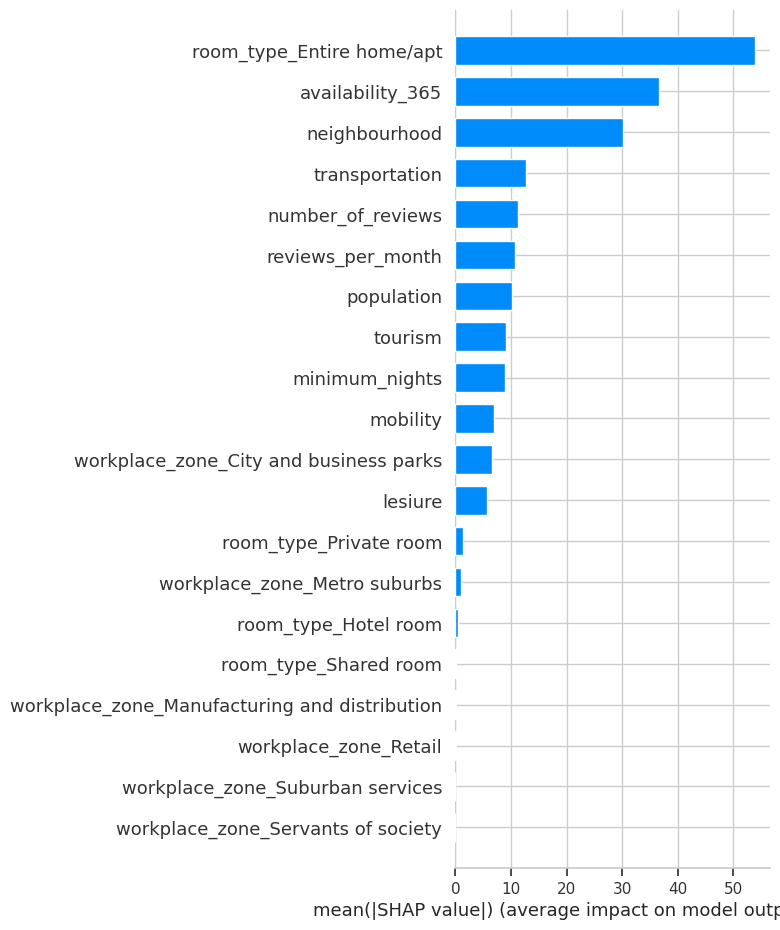

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


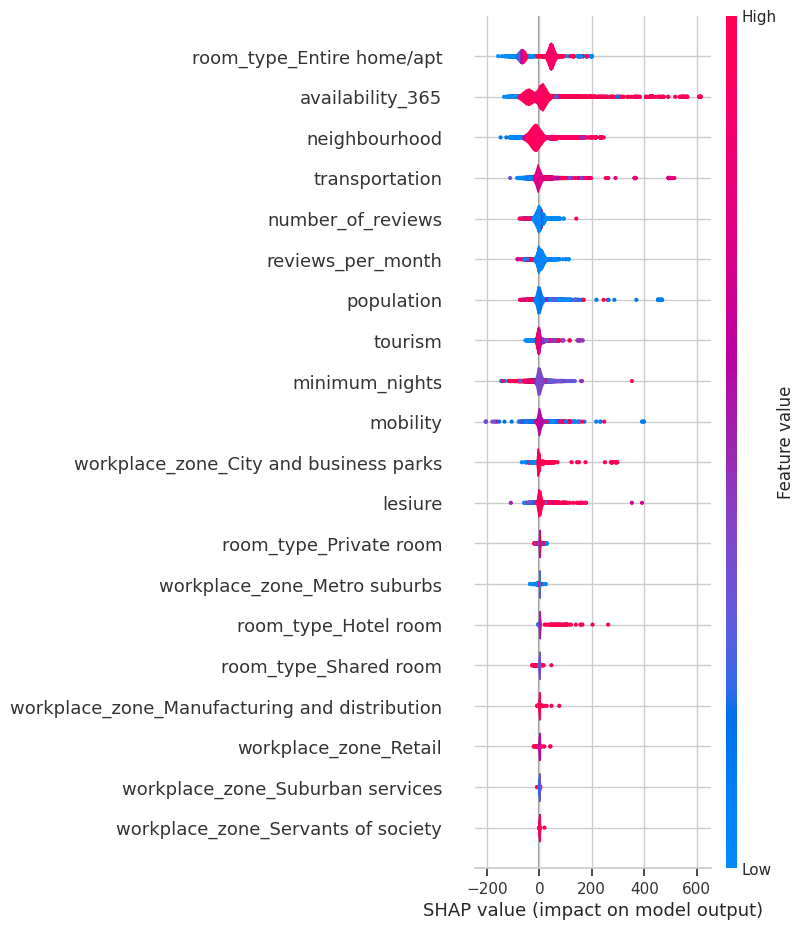

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='violin', show=True)

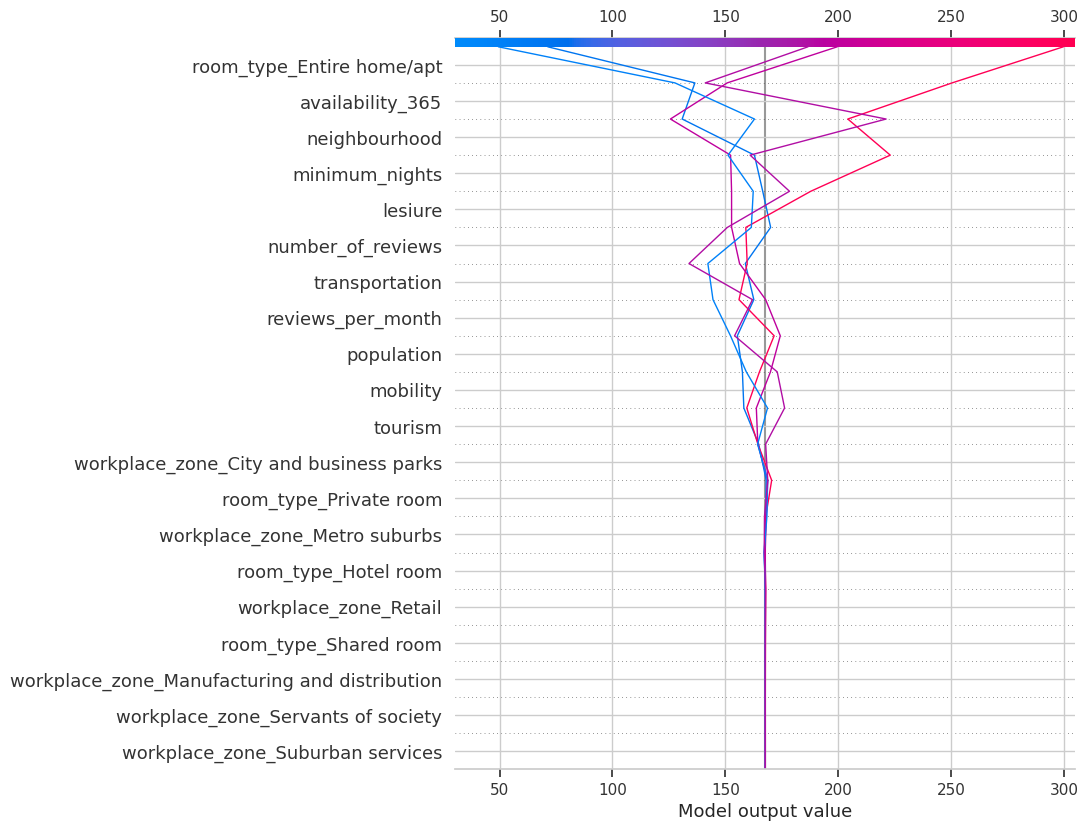

In [ ]:
select = range(5)
features = X_test.iloc[select]
shap_values = explainer.shap_values(features)

shap.decision_plot(expected_value, shap_values, features, show=True)

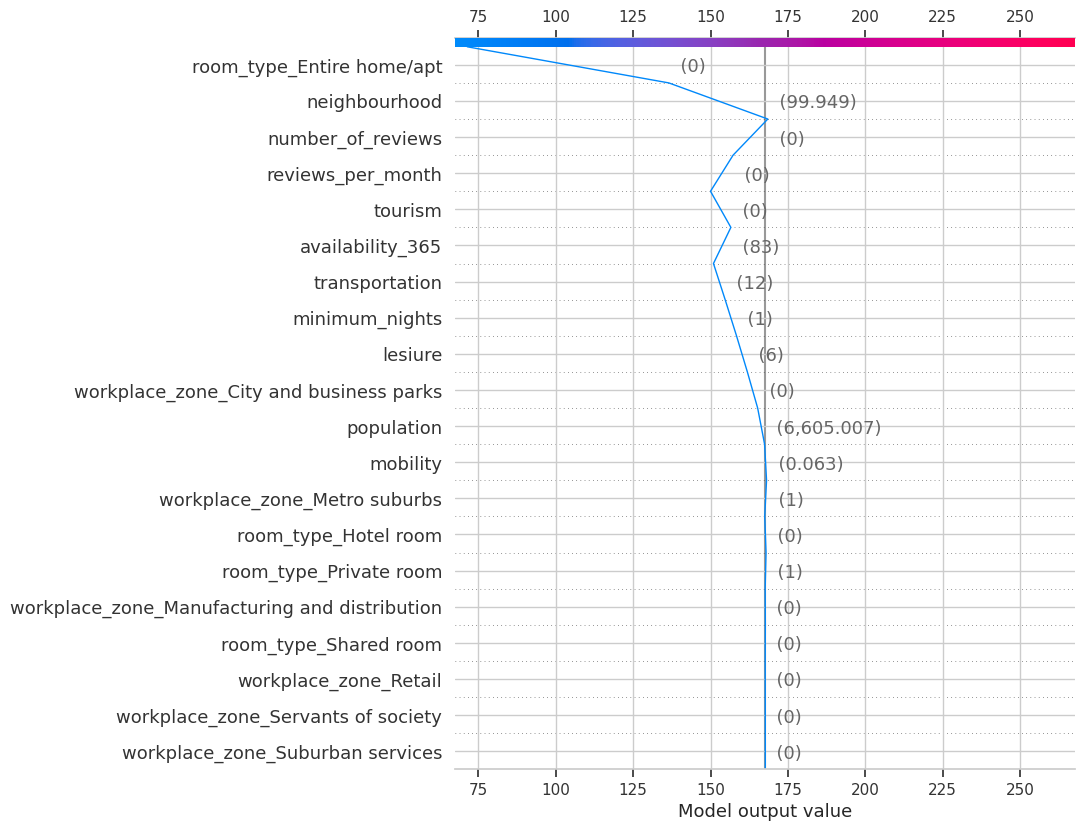

In [ ]:
select = range(1)
features = X_test.iloc[select]

shap_values = explainer.shap_values(features)
shap.decision_plot(expected_value, shap_values, features, show=True)

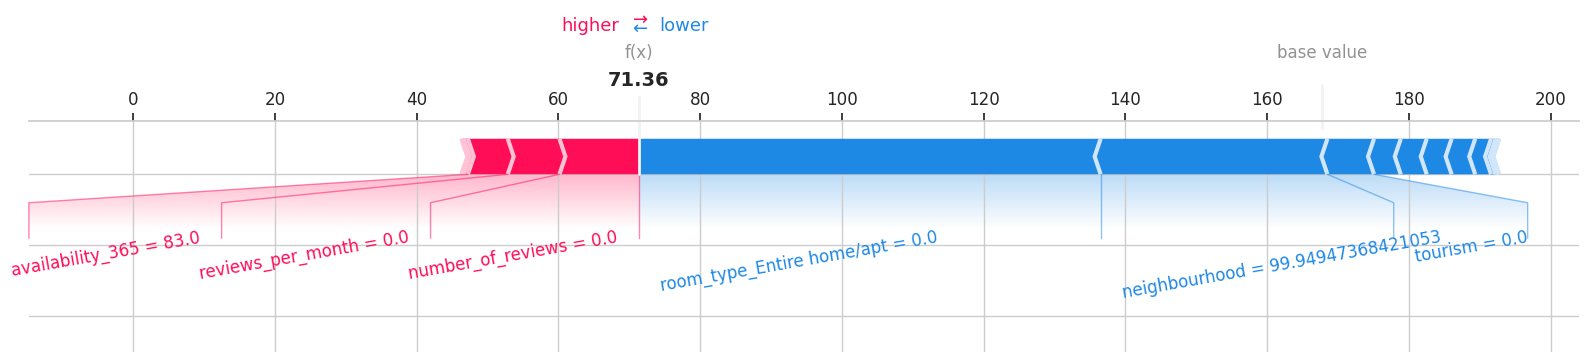

In [ ]:
select = range(1)
features = X_test.iloc[select]
shap_values = explainer.shap_values(features)

shap.force_plot(expected_value, shap_values, features, text_rotation=10, matplotlib=True)

# Model optimization


In [ ]:
reg_model = xgb.XGBRegressor(gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor')
grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [8, 10, 12],
    "min_child_weight": [1, 3],
    "gamma":[0.0, 0.1],
    "colsample_bytree":[0.5, 1]
}

grid_search = GridSearchCV(
            estimator=reg_model,
            param_grid=grid,
            cv=2,
            scoring='r2', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor='gpu_predictor',
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1], 'gamma': [0.0, 0.1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [8, 10, 12],
                         'min_child_weight': [1, 3]},
             scoring='r2', verbose=1)

In [ ]:
print (f"Best parameters: {grid_search.best_params_}")


Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 3}


In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,2.421974,0.101736,0.074356,0.002292,0.5,0.0,0.05,8,1,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.555068,0.539089,0.547079,0.007989,22
1,1.294619,0.005510,0.066635,0.001401,0.5,0.0,0.05,8,3,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.554334,0.538953,0.546644,0.007691,23
2,2.612384,0.047290,0.041119,0.000753,0.5,0.0,0.05,10,1,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.562896,0.546253,0.554575,0.008322,3
3,2.287627,0.000913,0.040282,0.001274,0.5,0.0,0.05,10,3,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.561256,0.545495,0.553375,0.007881,7
4,5.189754,0.008611,0.044086,0.001425,0.5,0.0,0.05,12,1,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.561896,0.546931,0.554414,0.007482,5


In [ ]:
# create model instance
xgb_model_opt = xgb.XGBRegressor(
    **grid_search.best_params_,
    n_estimators = 200,
    seed=39,
    eval_metric=["mae", "rmse"],
    gpu_id=0,
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)

# fit model
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model_opt.fit(X_train, y_train, verbose=0, eval_set=eval_set)

# make predictions
preds_opt = xgb_model_opt.predict(X_test)
predictions_opt = [round(value) for value in preds_opt]

# Adjusted R2
print("Adjusted R^2 :", 1 - (1-xgb_model_opt.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))
# R2 score
print("R^2 :", r2_score(y_test, predictions_opt))
# Mean Average Error
print("MAE :", mean_absolute_error(y_test,predictions_opt))
# Root Mean Squared Error
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions_opt)))

Adjusted R^2 : 0.7924867470200415
R^2 : 0.584180700689564
MAE : 69.11096678419001
RMSE: 129.47873735857388


# Prediction

In [ ]:
gdf_out = X_test.copy()
gdf_out['price_predicted'] = xgb_model_opt.predict(X_test)
gdf_out = gdf_out.merge(gdf_load, left_on='index', right_on='index')[['h3','price','price_predicted']]
gdf_out.reset_index(drop=True, inplace=True)
gdf_out

,h3,price,price_predicted
0,88195daee7fffff,125,87.377213
1,88194ada09fffff,599,291.294678
2,88194e69b1fffff,350,188.045563
3,88194ada0bfffff,98,32.889725
4,88194ada49fffff,230,226.200974
...,...,...,...
16162,88194ada19fffff,110,289.924042
16163,88194e699bfffff,165,219.815582
16164,88194ada0bfffff,96,82.470467
16165,88194ad73bfffff,495,276.347137


In [ ]:
from google.cloud import bigquery
job_config = bigquery.LoadJobConfig(schema=[], write_disposition="WRITE_TRUNCATE")
carto_dw_client.load_table_from_dataframe(gdf_out, "carto-dw-ac-u95100k3.shared_us.london_listings_2023_predicted", job_config=job_config).result()

LoadJob<project=carto-dw-ac-u95100k3, location=US, id=37580ff6-eeaa-4fdd-940f-add547c68802>

In [ ]:
#to list the tables contained in the dataset_id previously obtained
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'shared_us':
carto-dw-ac-u95100k3.shared_us.london_listings
carto-dw-ac-u95100k3.shared_us.london_listings_2023
carto-dw-ac-u95100k3.shared_us.london_listings_2023_joined
carto-dw-ac-u95100k3.shared_us.london_listings_2023_predicted
carto-dw-ac-u95100k3.shared_us.london_listings_joined
